In [1]:
import numpy as np
import pandas as pd
import scipy
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [2]:
ds = xr.open_dataset("C:/Users/mwood/1projects/rainfall_pred/data/processed/era5_conus_20240101.nc", engine="netcdf4")

In [3]:
input_vars = ['t2m', 'sp', 'u10', 'v10', 'cape']
target_var = 'tp_hourly'

# normalize per variable
for i_var in input_vars:
    mean = ds[i_var].mean()
    std = ds[i_var].std()
    ds[f"{i_var}_norm"] = (ds[i_var] - mean) / std

# print(ds.dims) # Frozen({'valid_time': 23, 'latitude': 101, 'longitude': 261})

# stack spatial dims into one: time, lat*lon, feature
X = np.stack([ds[f"{var}_norm"].values for var in input_vars], axis=-1)  # shape: time, lat, lon, features
Y = ds[target_var].values  # shape: time, lat, lon

# reshape to (samples, features) and (samples,)
n_time, n_lat, n_lon, n_feat = X.shape
X_flat = X.reshape(n_time * n_lat * n_lon, n_feat)
Y_flat = Y.reshape(n_time * n_lat * n_lon)

# we got the model at home
X_train, X_test, y_train, y_test = train_test_split(X_flat, Y_flat, test_size=0.25)
model = Ridge()
model.fit(X_train, y_train)

Ridge()

R² score: 0.0032
RMSE: 0.0791


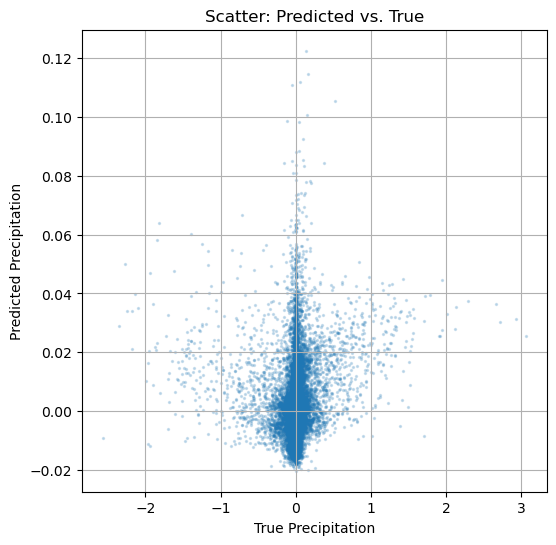

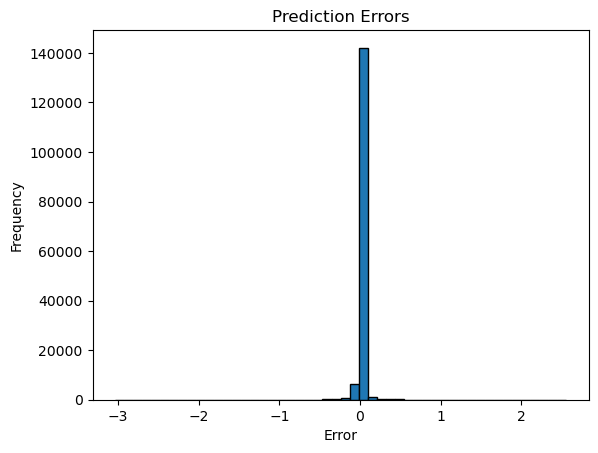

In [4]:
# eval stuff
# R²
score = model.score(X_test, y_test)
print(f"R² score: {score:.4f}")

# rmse
y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print(f"RMSE: {rmse:.4f}")

# scatter
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2, s=2)
plt.xlabel("true precip")
plt.ylabel("pred precip")
plt.title("prd v")
plt.grid(True)
plt.show()

# histogram
errors = y_pred - y_test
plt.hist(errors, bins=50, edgecolor='black')
plt.title("Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()